In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2539169%2F4310761%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240418%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240418T173301Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D369ec3b9a16109ac8685dcb0c5aea777ab12727bbbf78bcf61695a3729eb44349487b05d1b0b49b64aae84ceabc2965a2c663802dd5aaf46e335b31061110fe3d819f3526c4877a7ba03cfc4ac08bbdf65d29b9963aa7c2db5dbf0cf2d1c3e895b2135848be956b602f1a3852a6b8965eecd911d8ae55bcfe960f658a682ec494aa74b17cf44ff676f1a4e9194344df7be0252d58d856b55284926ba7e8469ae07182bfcb2d9b504f0bcc01c8cb095e32c9985a04e86a2c830ba496e3b8278ebf50838e974350dbbe17e4fb2c8b630ded443f7b5418e3ad7fba875bd58c23d447684978703b30fe9703a96c5426aa525219d90dc36bb685db00ace60eba1124d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 327254538 bytes downloaded
Downloaded and uncompressed: brain-tumor-segmentation
Data source import complete.


In [2]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
from glob import glob
import time
import json
from sklearn.model_selection import KFold
import numpy as np
import cv2
import tensorflow as tf
from datetime import datetime
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation

In [3]:
IMAGE_SIZE = (256, 256)

train_files = glob.glob('../input/brain-tumor-segmentation/images/*.png')
mask_files = glob.glob('../input/brain-tumor-segmentation/masks/*.png')

EPOCHS = 80
BATCH_SIZE = 32

In [4]:
def diagnosis(mask):
    value = np.max(cv2.imread(mask))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image_path": train_files,
                    "mask_path": mask_files,
                    "diagnosis": [diagnosis(x) for x in mask_files]})
df.head()

,image_path,mask_path,diagnosis
0,../input/brain-tumor-segmentation/images/2763.png,../input/brain-tumor-segmentation/masks/2763.png,1
1,../input/brain-tumor-segmentation/images/2736.png,../input/brain-tumor-segmentation/masks/2736.png,1
2,../input/brain-tumor-segmentation/images/1869.png,../input/brain-tumor-segmentation/masks/1869.png,1
3,../input/brain-tumor-segmentation/images/430.png,../input/brain-tumor-segmentation/masks/430.png,1
4,../input/brain-tumor-segmentation/images/2086.png,../input/brain-tumor-segmentation/masks/2086.png,1


In [5]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2213, 3)
(391, 3)
(460, 3)


In [7]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

In [8]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE, train_generator_args, target_size=IMAGE_SIZE)

val_gen = train_generator(df_val, BATCH_SIZE, dict(), target_size=IMAGE_SIZE)

test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=IMAGE_SIZE)

# **Dice and IoU Loss Functions**

In [9]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def iou_loss(y_true, y_pred):
    return 1 - iou(y_true, y_pred)

In [10]:
def conv_block1(inputs, filters):
    x = Conv2D(filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def encoder_block1(inputs, filters):
    x = conv_block1(inputs, filters)
    p = MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

def decoder_block1(inputs, filters, concat_layer):
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    x = concatenate([x, concat_layer])
    x = conv_block1(x, filters)
    return x

def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block1(inputs, 32)
    s2, p2 = encoder_block1(p1, 64)
    s3, p3 = encoder_block1(p2, 128)
    s4, p4 = encoder_block1(p3, 256)

    b1 = conv_block1(p4, 512)

    d1 = decoder_block1(b1, 256, s4)
    d2 = decoder_block1(d1, 128, s3)
    d3 = decoder_block1(d2, 64, s2)
    d4 = decoder_block1(d3, 32, s1)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(d4)

    unet_model = Model(inputs, outputs, name="UNet")
    return unet_model

unet_model = unet((256, 256, 1))
unet_model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normalization[0][0]

In [11]:
opt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)
unet_model.compile(optimizer=opt, loss=bce_dice_loss, metrics=["accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=0, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
             EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

history_unet = unet_model.fit(train_gen,
                              steps_per_epoch=len(df_train) / BATCH_SIZE,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              validation_data=val_gen,
                              validation_steps=len(df_val) / BATCH_SIZE)

Found 2213 validated image filenames.
Found 2213 validated image filenames.
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


70/69 [==============================] - ETA: 0s - loss: 1.4436 - accuracy: 0.8475 - iou: 0.0202 - dice_coef: 0.0396Found 391 validated image filenames.
Found 391 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 109s 942ms/step - loss: 1.4436 - accuracy: 0.8475 - iou: 0.0202 - dice_coef: 0.0396 - val_loss: 1.6162 - val_accuracy: 0.9781 - val_iou: 0.0173 - val_dice_coef: 0.0340 - lr: 1.0000e-04
Epoch 2/80
69/69 [==============================] - 51s 739ms/step - loss: 1.2229 - accuracy: 0.9817 - iou: 0.0216 - dice_coef: 0.0422 - val_loss: 1.5266 - val_accuracy: 0.9821 - val_iou: 0.0175 - val_dice_coef: 0.0345 - lr: 1.0000e-04
Epoch 3/80
69/69 [==============================] - 53s 767ms/step - loss: 1.1680 - accuracy: 0.9767 - iou: 0.0330 - dice_coef: 0.0638 - val_loss: 1.5345 - val_accuracy: 0.8776 - val_iou: 0.0173 - val_dice_coef: 0.0340 - lr: 1.0000e-04
Epoch 4/80
69/69 [==============================] - 52s 751ms/step - loss: 1.1090 - accuracy: 0.9759 - iou: 0.0526 - dice_coef: 0.0998 - val_loss: 1.3038 - val_accuracy: 0.9734 - val_iou: 0.0133 - val_dice_coef: 0.0262 - lr: 1.0000e-04
Epoch 5/80
69/69 [==============================] - 51s 739ms/step

In [12]:
model = load_model('unet.hdf5', custom_objects={'bce_dice_loss': bce_dice_loss, 'accuracy': "accuracy", 'iou': iou, 'dice_coef': dice_coef})
results = unet_model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Loss:", results[0])
print("Accuracy:", results[1])
print("IoU Score:", results[2])
print("Dice Score:", results[3])

Found 460 validated image filenames.
Found 460 validated image filenames.
14/14 [==============================] - 8s 577ms/step - loss: 0.2220 - accuracy: 0.9944 - iou: 0.6733 - dice_coef: 0.8033
Loss: 0.2219735085964203
Accuracy: 0.9944191575050354
IoU Score: 0.6732901334762573
Dice Score: 0.8033320903778076


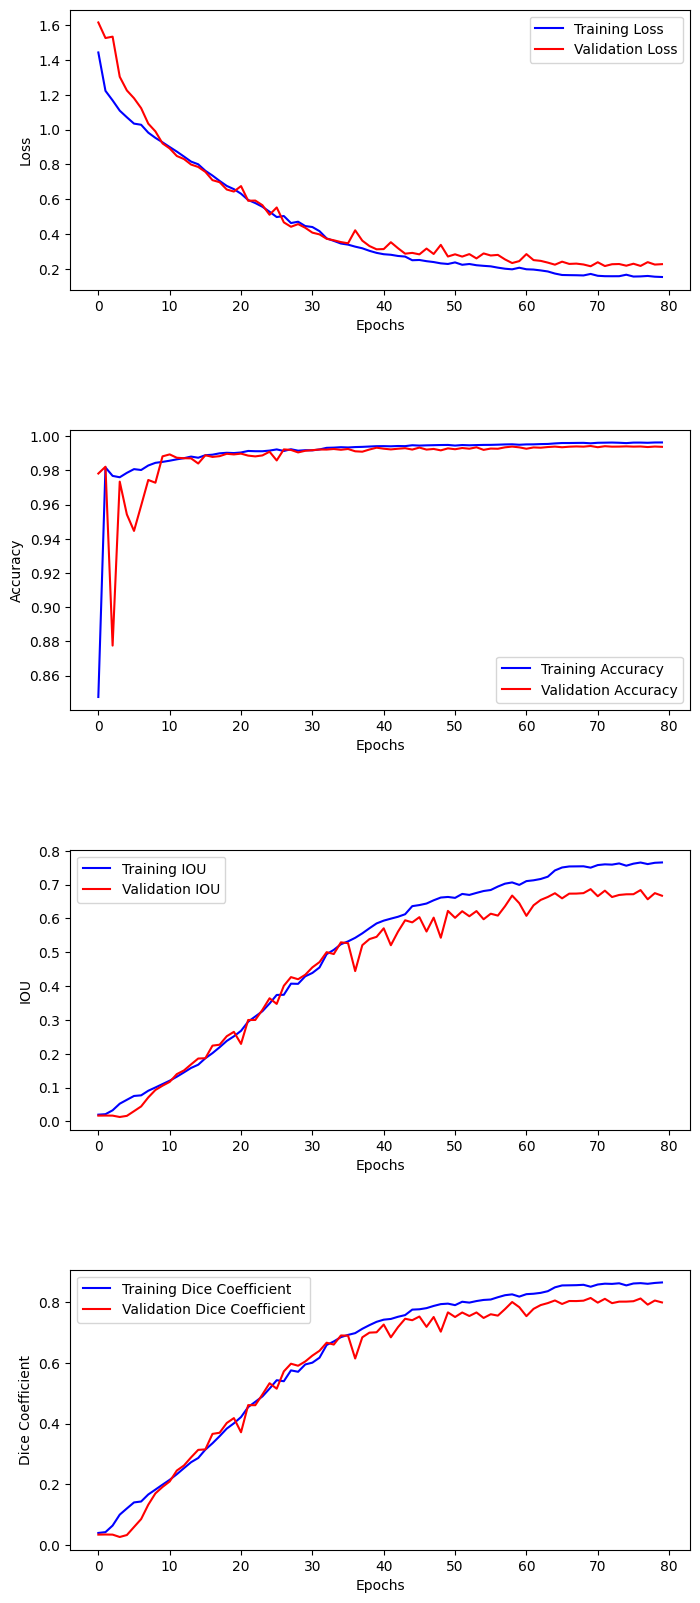

In [13]:
history_dict = history_unet.history
pd.DataFrame.from_dict(history_dict).to_csv('history_unet.csv', index = False)
history_unet_df = pd.read_csv('history_unet.csv')

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 20))
plt.subplots_adjust(hspace=0.5)

# Plot the loss
axs[0].plot(history_unet_df['loss'], 'b-', label='Training Loss')
axs[0].plot(history_unet_df['val_loss'], 'r-', label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='best')

axs[1].plot(history_unet_df['accuracy'], 'b-', label='Training Accuracy')
axs[1].plot(history_unet_df['val_accuracy'], 'r-', label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='best')

axs[2].plot(history_unet_df['iou'], 'b-', label='Training IOU')
axs[2].plot(history_unet_df['val_iou'], 'r-', label='Validation IOU')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('IOU')
axs[2].legend(loc='best')

axs[3].plot(history_unet_df['dice_coef'], 'b-', label='Training Dice Coefficient')
axs[3].plot(history_unet_df['val_dice_coef'], 'r-', label='Validation Dice Coefficient')
axs[3].set_xlabel('Epochs')
axs[3].set_ylabel('Dice Coefficient')
axs[3].legend(loc='best')

plt.show()

1/1 [==============================] - 2s 2s/step


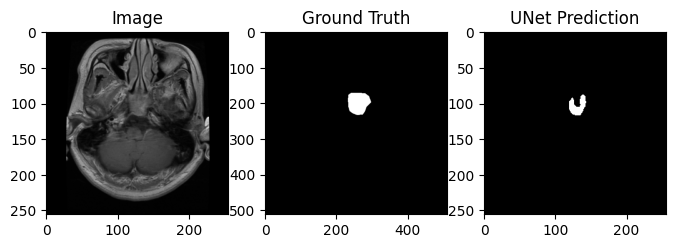

UNet Inference Time: 2461.5314 ms
1/1 [==============================] - 0s 20ms/step


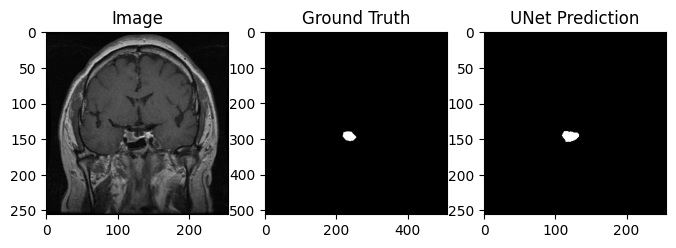

UNet Inference Time: 80.0581 ms
1/1 [==============================] - 0s 20ms/step


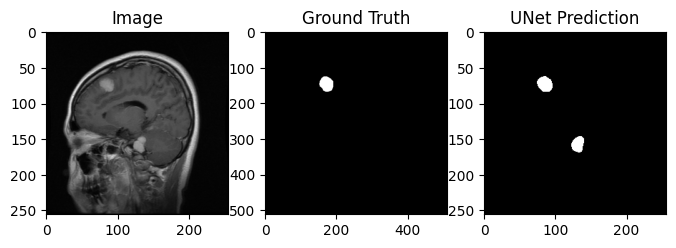

UNet Inference Time: 69.1249 ms
1/1 [==============================] - 0s 20ms/step


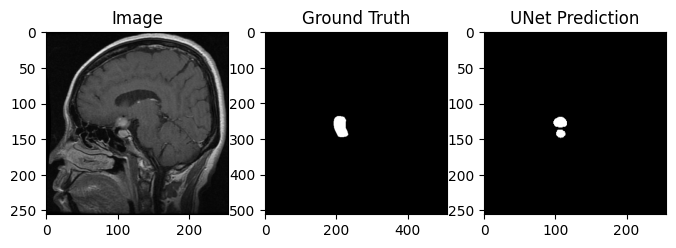

UNet Inference Time: 75.5465 ms
1/1 [==============================] - 0s 19ms/step


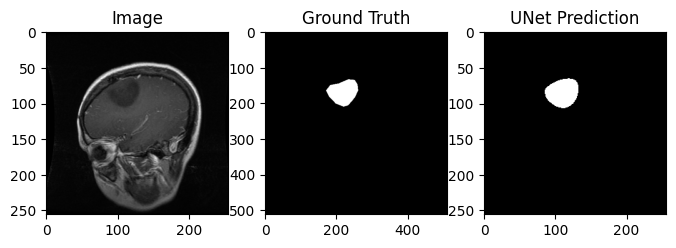

UNet Inference Time: 70.9350 ms
1/1 [==============================] - 0s 19ms/step


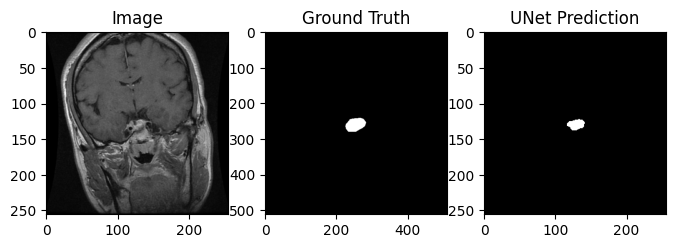

UNet Inference Time: 84.9874 ms
1/1 [==============================] - 0s 18ms/step


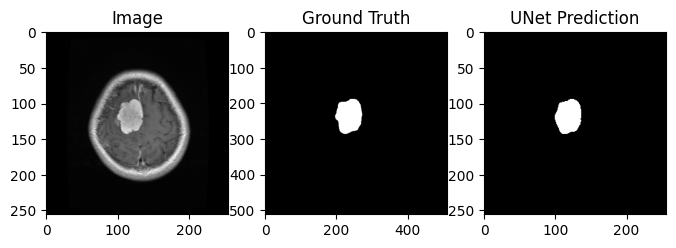

UNet Inference Time: 76.6580 ms
1/1 [==============================] - 0s 18ms/step


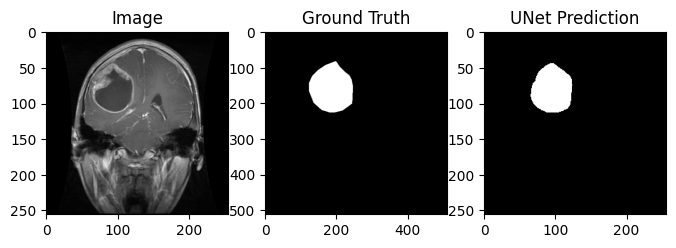

UNet Inference Time: 69.7072 ms
1/1 [==============================] - 0s 18ms/step


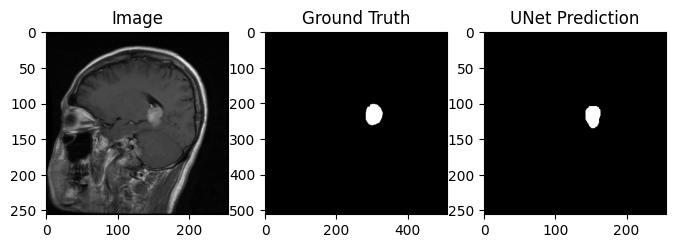

UNet Inference Time: 77.0190 ms
1/1 [==============================] - 0s 18ms/step


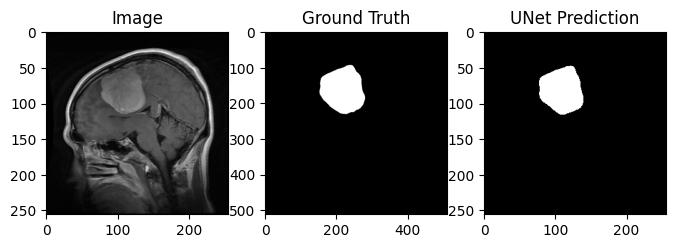

UNet Inference Time: 78.0916 ms


In [14]:
for i in range(10):
    index = np.random.randint(1, len(df_test.index))

    img = cv2.imread(df_test['image_path'].iloc[index], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMAGE_SIZE)
    img = img / 255
    img = img[:, :, np.newaxis]
    img = np.expand_dims(img, axis=0)

    start_time = time.time()
    pred_unet = unet_model.predict(img)
    end_time = time.time()
    unet_inference_time = (end_time - start_time) * 1000

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img), cmap='gray')
    plt.title('Image')
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])), cmap='gray')
    plt.title('Ground Truth')
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_unet) > .5, cmap='gray')
    plt.title('UNet Prediction')
    plt.show()

    print(f'UNet Inference Time: {unet_inference_time:.4f} ms')
